# Homework 3

## Part 0
I use the income prediction data set with a set of variables (columns of data) to predict whether an individual earns above 50,000 of some specific currency.  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# read the raw training data from csv file to a pandas dataframe
import pandas as pd
raw_training_data = pd.read_csv('/content/drive/MyDrive/STA365_DataSet/Train.csv')

## Part I
We choose the column of data called "importance_of_record" to run the posterior inference with a PyMC normal-gamma specification


In [ ]:
import numpy as np
import pymc as pm

# retreive the column data and convert it to numpy array
x = np.array(raw_training_data['importance_of_record'])

# Initialize Prior Hyperparameters
theta_0,tau = 0,1;  # Normal-Prior for theta (mean/location parameter for observe data)
a,b = 2,1/2  # Beta Prior for phi (scale parameter for observe data)

# Initialize the normal_gamma_model
normal_gamma_toy_model = pm.Model()
with normal_gamma_toy_model:
    theta = pm.Normal("theta", mu=theta_0, sigma=tau)
    phi = pm.Gamma("phi", alpha=a, beta=b)
    x_obs = pm.Normal("likelihood", mu=theta, sigma=1/phi**0.5, observed=x)

In [ ]:
# Set Seed
np.random.seed(seed=123)

# Conduct Hamiltonian Monte Carlo (HMC)
with normal_gamma_toy_model:
    idata_HMC = pm.sample(2000, chains=4, cores=4) # default is the NUTS implementation of HMC

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


### Sanity Check of Convergence


HMC Split-Rhats {'theta': 1.0005, 'phi': 1.0005}


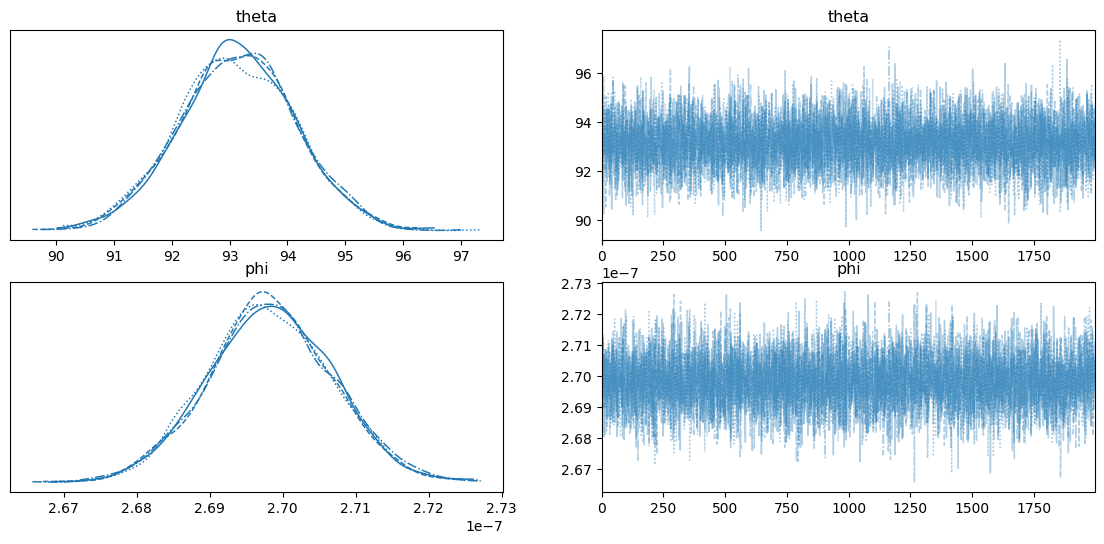

In [73]:
import arviz as az; import matplotlib.pyplot as plt;
fig,ax = plt.subplots(2,2, figsize=(14,6))
az.plot_trace(idata_HMC, axes=ax[:2,:2])
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(idata_HMC).items()})

### Credible Intervals - HDI

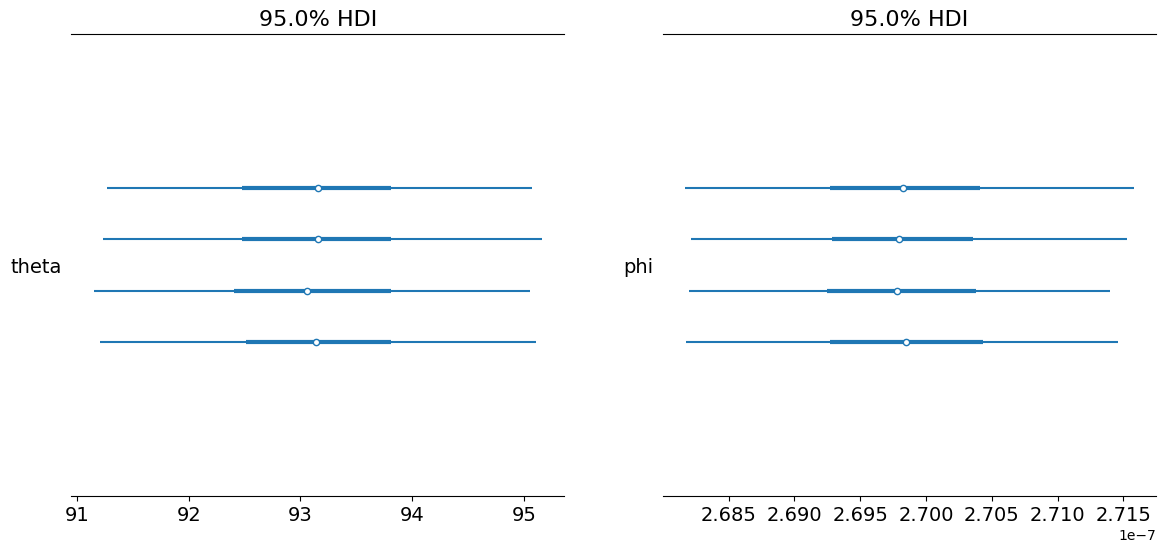

In [ ]:
import arviz as az; import matplotlib.pyplot as plt; fig,ax = plt.subplots(1,2, figsize=(14,6))
az.plot_forest(idata_HMC, var_names=["theta"], combined=False, hdi_prob=0.95, ax=ax[0]);
az.plot_forest(idata_HMC, var_names=["phi"], combined=False, hdi_prob=0.95, ax=ax[1]);

## Part II
We choose the column of data called "gender" to run the posterior inference with a non normal-gamma specification PyMC. <br>
In particular, we represent Male = 1, Female = 0 such that the observed gender data follows a Bernouli distribution which is parmaterized by $\rho$, where<br>
<center>
  $\rho$ = Pr(An individual is a Male)
</center>
Moreover, we assume $\rho \sim Unif[0,1]$, a standard uniform prior

In [ ]:
# retreive the column data and convert it to numpy array
g = np.array(pd.get_dummies(raw_training_data['gender']))

# Initialize Prior Hyperparameters
l, u = 0,1;  # Uniform Prior for rho

# Initialize the Bernoulli_Uniform_model
bernoulli_unif_model = pm.Model()
with bernoulli_unif_model:
    rho = pm.Uniform("rho", lower = l, upper = u)
    g_obs = pm.Bernoulli("likelihood", p=rho, observed=g)

## Conduct the PyMC



In [ ]:
# Conduct Hamiltonian Monte Carlo (HMC)
with bernoulli_unif_model:
    gdata_HMC = pm.sample(2000, chains=4, cores=4) # default is the NUTS implementation of HMC

MCMC Bayesian Inference: Credible Intervals - HPD

In [ ]:
# Output the 95% Highest Density Interval
interval = az.hdi(gdata_HMC)
print(interval)

<xarray.Dataset>
Dimensions:  (hdi: 2)
Coordinates:
  * hdi      (hdi) <U6 'lower' 'higher'
Data variables:
    rho      (hdi) float64 0.4986 0.5015


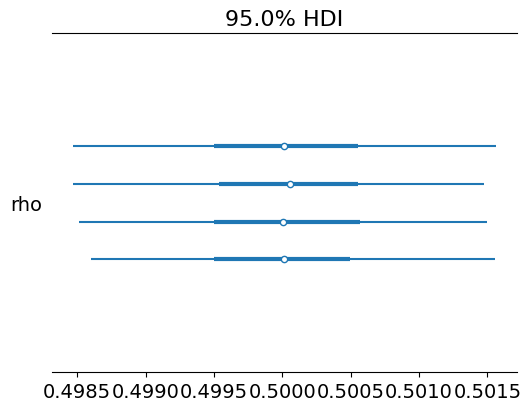

In [ ]:
# Print the 95.0% HDI
az.plot_forest(gdata_HMC, var_names=["rho"], combined=False, hdi_prob=0.95);

## Sanity Check of Convergence
We check whether the MCMC converge to the so-call "stable" distribution by ploting the sample mc trials with 4 distinct initial values of $\rho$. The plot suggest that they all converge to a similar "stable" distribution. Moreover, the Split-$\hat{R}$ statistics is $1.0001$, which also suggests that we have convergence in the MCMC

HMC Split-Rhats {'rho': 1.0001}


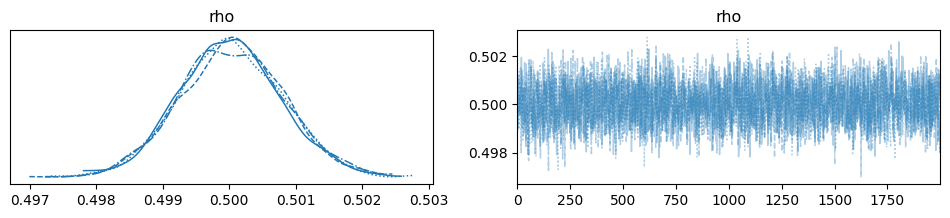

In [ ]:
az.plot_trace(gdata_HMC)
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(gdata_HMC).items()})

## MCMC Chain Analysis
We conduct MCMC Chain analysis by ploting the MC chain, analysing its auto-correlation and effective sample size


## MC Chain plots

Text(0.5, 1.0, 'HMC - Empirical Distribution')

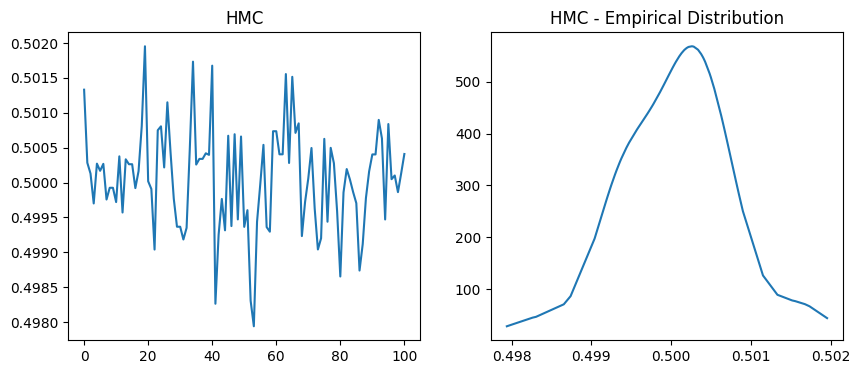

In [ ]:
from scipy.stats import gaussian_kde; import matplotlib.pyplot as plt;
n_mcmc_samples = 100
fig,ax = plt.subplots(1,2, figsize=(10,4))
mcmc_chain = gdata_HMC.posterior["rho"].sel(chain=0, draw=slice(0, n_mcmc_samples)).values
mcmc_chain_sorted = sorted(mcmc_chain)
ax[0].plot(mcmc_chain);
ax[1].plot(mcmc_chain_sorted,gaussian_kde(mcmc_chain_sorted)(mcmc_chain_sorted));
ax[0].set_title("HMC");
ax[1].set_title("HMC - Empirical Distribution")

## Auto-Correlation Plot
We compute and plot the auto-correlation for the MCMC chain below. We can see that the autocorrelation for this particular MCMC chain is 0.36. This number is significantly larger than 0. So, it suggests that the terms in our MCMC chain is relatively stickly with each other. As a results, it takes a longer time for the chain to converge to the stable distribution.

Autocorrelation for HMC (MCMC) chain 0.361374815809621


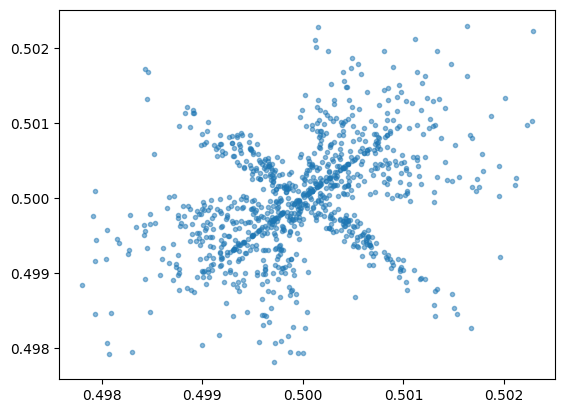

In [83]:
import numpy as np; import matplotlib.pyplot as plt;
fig,ax = plt.subplots(1,1)
max_mcmc_samples = 1000
mcmc_chain = gdata_HMC.posterior["rho"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values;
mcmc_chain_one_step_ahead = gdata_HMC.posterior["rho"].sel(chain=0, draw=slice(1, max_mcmc_samples-1)).values;
ax.plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5)
print("Autocorrelation for HMC (MCMC) chain", np.corrcoef(mcmc_chain,mcmc_chain_one_step_ahead)[0,1])

## Effective Sample Size
We compute the effecitve sample size in this step. This is an alternative metric to assess the efficiency of our HMC approach.<br>
According to the computation, given a 8000 samples, the effective sample size is around 3555. Which is significantly lower. This observation is as expected since we have a fairly large autocorrelation of the MCMC chain.

In [87]:
import arviz as az; print("number of MCMC samples:", gdata_HMC.posterior['rho'].values.flatten().shape[-1])
az.summary(gdata_HMC, round_to=4)

number of MCMC samples: 8000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rho,0.5,0.0008,0.4986,0.5015,0.0,0.0,3555.4679,5525.8659,1.0001
